In [7]:
train_data_dir = "/kaggle/input/vietnamesefoods/FOOD-DATASET/TRAIN"
val_data_dir = "/kaggle/input/vietnamesefoods/FOOD-DATASET/VAL"
test_data_dir = "/kaggle/input/vietnamesefoods/FOOD-DATASET/TEST"

In [27]:
from torch.utils.data import Dataset
from PIL import Image, ImageDraw
import numpy as np
from xml.etree import ElementTree as ET
import os
import torch

class Dataset(Dataset):
    def __init__(self, data_dir, transform):
        self.data_dir = data_dir
        self.samples = self.load_data(data_dir)
        self.transform = transform

        self.labels = sorted(set(sample['label'] for sample in self.samples))
        self.label_to_idx = {label: idx for idx, label in enumerate(self.labels)}

    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, index):
        # get sample at indes
        sample = self.samples[index]

        # set up image's path
        filename = sample['filename']
        image_path = os.path.join(self.data_dir, filename)

        # open image
        image = Image.open(image_path).convert('RGB')
        
        # image = np.array(image)
        transform_image = self.transform(image)

        label = self.label_to_idx[sample['label']]
        label = torch.tensor(label, dtype=torch.long)
        
        return transform_image, label

    def load_data(self, data_dir):
        data = []
        
        for label in os.listdir(data_dir):
            label_path = os.path.join(data_dir, label)
            if os.path.isdir(label_path):
                for img_file in os.listdir(label_path):
                    img_path = os.path.join(label_path, img_file)
                    data.append({'filename': img_path, 'label': label})
        return data

In [28]:
import torch
from torchvision import datasets, transforms

transform = transforms.Compose([
    transforms.Resize((256, 256)), # Resize 256x256
    transforms.RandomRotation(30), # Xoay ngẫu nhiên ảnh trong khoảng từ -30 đến 30 độ
    transforms.RandomAffine(degrees=0, translate=(0.05, 0.05)), # Dịch ngẫu nhiên từ -5 đến 5 pixel theo cả hai hướng (x, y)
    transforms.ToTensor(), # Chuyển đổi ảnh thành tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [29]:
train_dataset = Dataset(train_data_dir, transform)
val_dataset = Dataset(val_data_dir, transform) 
test_dataset = Dataset(test_data_dir, transform)

In [30]:
len(train_dataset), len(val_dataset), len(test_dataset)

(18751, 2757, 5169)

In [31]:
img, label = train_dataset[3]
img.shape, label

(torch.Size([3, 256, 256]), tensor(5))

In [32]:
import torch.nn as nn

class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += self.shortcut(x)
        out = self.relu(out)
        return out

In [33]:
class ResNet18(nn.Module):
    def __init__(self, num_classes=38):
        super(ResNet18, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.layer1 = self._make_layer(BasicBlock, 64, 2, stride=1)
        self.layer2 = self._make_layer(BasicBlock, 128, 2, stride=2)
        self.layer3 = self._make_layer(BasicBlock, 256, 2, stride=2)
        self.layer4 = self._make_layer(BasicBlock, 512, 2, stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.maxpool(out)
        
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

In [34]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [35]:
import torch.optim as optim
from torchvision import datasets, transforms
from tqdm import tqdm

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=8, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=8, shuffle=False)

In [36]:
import torch.optim as optim
import torch.nn.functional as F

weight_decay = 1e-4 

model = ResNet18().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(
    model.parameters(), 
    lr=0.005, 
    momentum=0.9, 
    weight_decay=weight_decay
)

In [37]:
param_count = sum(p.numel() for p in model.parameters())
param_count

11188326

In [38]:
num_epochs = 20

In [39]:
from tqdm import tqdm
from sklearn.metrics import f1_score

train_losses = []
train_accuracy = []
val_losses = []
val_accuracy = []

# Train Network
for epoch in range(num_epochs):
    train_labels = []
    train_preds = []
    val_labels = []
    val_preds = []

    # Training
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for data in tqdm(train_loader):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        train_labels.extend(labels.cpu().numpy())
        train_preds.extend(predicted.cpu().numpy())

    epoch_loss = running_loss / len(train_loader)
    accuracy = 100 * correct / total
    f1_train = f1_score(train_labels, train_preds, average='macro')
    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {epoch_loss:.4f}, Accuracy: {accuracy:.2f}%, F1: {f1_train:.4f}")

    # Validation
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for data in tqdm(val_loader):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            val_labels.extend(labels.cpu().numpy())
            val_preds.extend(predicted.cpu().numpy())

    epoch_loss = running_loss / len(val_loader)
    accuracy = 100 * correct / total
    f1_val = f1_score(val_labels, val_preds, average='macro')
    print(f"Validation Loss: {epoch_loss:.4f}, Accuracy: {accuracy:.2f}%, F1: {f1_val:.4f}")

 36%|███▋      | 850/2344 [04:38<07:36,  3.27it/s]/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 2344/2344 [12:39<00:00,  3.09it/s]


Epoch 1/20 - Train Loss: 3.2605, Accuracy: 12.19%, F1: 0.0761


100%|██████████| 345/345 [01:26<00:00,  4.01it/s]


Validation Loss: 3.1719, Accuracy: 13.38%, F1: 0.0716


  1%|          | 23/2344 [00:06<14:29,  2.67it/s]/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 2344/2344 [09:51<00:00,  3.97it/s]


Epoch 2/20 - Train Loss: 2.8954, Accuracy: 20.97%, F1: 0.1532


100%|██████████| 345/345 [01:02<00:00,  5.53it/s]


Validation Loss: 2.6799, Accuracy: 27.49%, F1: 0.2020


  1%|          | 22/2344 [00:05<09:23,  4.12it/s]/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 2344/2344 [09:53<00:00,  3.95it/s]


Epoch 3/20 - Train Loss: 2.5953, Accuracy: 28.09%, F1: 0.2235


100%|██████████| 345/345 [01:02<00:00,  5.50it/s]


Validation Loss: 2.4535, Accuracy: 33.22%, F1: 0.2780


 60%|██████    | 1413/2344 [05:56<05:23,  2.88it/s]/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 2344/2344 [09:54<00:00,  3.94it/s]


Epoch 4/20 - Train Loss: 2.3341, Accuracy: 34.45%, F1: 0.2881


100%|██████████| 345/345 [01:02<00:00,  5.54it/s]


Validation Loss: 2.3294, Accuracy: 36.02%, F1: 0.3159


 40%|███▉      | 930/2344 [04:00<06:26,  3.66it/s]/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 2344/2344 [09:56<00:00,  3.93it/s]


Epoch 5/20 - Train Loss: 2.1191, Accuracy: 39.93%, F1: 0.3507


100%|██████████| 345/345 [01:02<00:00,  5.55it/s]


Validation Loss: 2.1048, Accuracy: 41.86%, F1: 0.3734


  2%|▏         | 51/2344 [00:12<08:48,  4.34it/s]/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 2344/2344 [09:52<00:00,  3.95it/s]


Epoch 6/20 - Train Loss: 1.9229, Accuracy: 45.27%, F1: 0.4031


100%|██████████| 345/345 [01:02<00:00,  5.56it/s]


Validation Loss: 1.8994, Accuracy: 47.08%, F1: 0.4427


 53%|█████▎    | 1254/2344 [05:15<04:12,  4.31it/s]/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 2344/2344 [09:51<00:00,  3.96it/s]


Epoch 7/20 - Train Loss: 1.7414, Accuracy: 50.05%, F1: 0.4617


100%|██████████| 345/345 [01:02<00:00,  5.53it/s]


Validation Loss: 1.5979, Accuracy: 54.66%, F1: 0.5258


 58%|█████▊    | 1367/2344 [05:44<03:41,  4.41it/s]/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 2344/2344 [09:53<00:00,  3.95it/s]


Epoch 8/20 - Train Loss: 1.5941, Accuracy: 54.71%, F1: 0.5067


100%|██████████| 345/345 [01:02<00:00,  5.53it/s]


Validation Loss: 1.5354, Accuracy: 56.58%, F1: 0.5392


 50%|█████     | 1180/2344 [04:59<06:38,  2.92it/s]/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 2344/2344 [09:51<00:00,  3.96it/s]


Epoch 9/20 - Train Loss: 1.4576, Accuracy: 58.11%, F1: 0.5424


100%|██████████| 345/345 [01:02<00:00,  5.51it/s]


Validation Loss: 1.4595, Accuracy: 59.45%, F1: 0.5588


 31%|███       | 730/2344 [03:04<06:33,  4.10it/s]/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 2344/2344 [09:51<00:00,  3.96it/s]


Epoch 10/20 - Train Loss: 1.3506, Accuracy: 61.03%, F1: 0.5735


100%|██████████| 345/345 [01:03<00:00,  5.45it/s]


Validation Loss: 1.4095, Accuracy: 59.99%, F1: 0.5683


 30%|██▉       | 699/2344 [02:54<06:33,  4.18it/s]/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 2344/2344 [09:53<00:00,  3.95it/s]


Epoch 11/20 - Train Loss: 1.2564, Accuracy: 63.30%, F1: 0.5994


100%|██████████| 345/345 [01:02<00:00,  5.56it/s]


Validation Loss: 1.3586, Accuracy: 63.33%, F1: 0.6104


 10%|█         | 244/2344 [01:02<07:52,  4.44it/s]/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 2344/2344 [09:53<00:00,  3.95it/s]


Epoch 12/20 - Train Loss: 1.1733, Accuracy: 65.61%, F1: 0.6276


100%|██████████| 345/345 [01:02<00:00,  5.48it/s]


Validation Loss: 1.2661, Accuracy: 64.09%, F1: 0.6122


 58%|█████▊    | 1350/2344 [05:43<03:31,  4.70it/s]/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 2344/2344 [09:53<00:00,  3.95it/s]


Epoch 13/20 - Train Loss: 1.0946, Accuracy: 68.11%, F1: 0.6519


100%|██████████| 345/345 [01:03<00:00,  5.47it/s]


Validation Loss: 1.1786, Accuracy: 66.74%, F1: 0.6308


  7%|▋         | 158/2344 [00:40<08:51,  4.11it/s]/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 2344/2344 [09:54<00:00,  3.95it/s]


Epoch 14/20 - Train Loss: 1.0227, Accuracy: 70.05%, F1: 0.6724


100%|██████████| 345/345 [01:02<00:00,  5.51it/s]


Validation Loss: 1.3463, Accuracy: 64.06%, F1: 0.6184


 29%|██▉       | 681/2344 [02:54<07:02,  3.94it/s]/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 2344/2344 [09:54<00:00,  3.95it/s]


Epoch 15/20 - Train Loss: 0.9581, Accuracy: 71.62%, F1: 0.6852


100%|██████████| 345/345 [01:03<00:00,  5.44it/s]


Validation Loss: 1.0998, Accuracy: 69.10%, F1: 0.6687


 29%|██▊       | 669/2344 [02:50<06:17,  4.44it/s]/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 2344/2344 [09:51<00:00,  3.96it/s]


Epoch 16/20 - Train Loss: 0.9066, Accuracy: 73.34%, F1: 0.7060


100%|██████████| 345/345 [01:03<00:00,  5.48it/s]


Validation Loss: 1.0473, Accuracy: 71.31%, F1: 0.6956


 36%|███▌      | 843/2344 [03:34<05:49,  4.29it/s]/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 2344/2344 [09:54<00:00,  3.94it/s]


Epoch 17/20 - Train Loss: 0.8523, Accuracy: 74.92%, F1: 0.7211


100%|██████████| 345/345 [01:02<00:00,  5.48it/s]


Validation Loss: 1.1270, Accuracy: 68.84%, F1: 0.6680


 19%|█▉        | 448/2344 [01:51<09:23,  3.36it/s]/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 2344/2344 [09:53<00:00,  3.95it/s]


Epoch 18/20 - Train Loss: 0.8055, Accuracy: 76.12%, F1: 0.7348


100%|██████████| 345/345 [01:02<00:00,  5.52it/s]


Validation Loss: 1.0125, Accuracy: 70.95%, F1: 0.6906


 73%|███████▎  | 1708/2344 [07:12<03:13,  3.28it/s]/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 2344/2344 [09:53<00:00,  3.95it/s]


Epoch 19/20 - Train Loss: 0.7628, Accuracy: 77.56%, F1: 0.7548


100%|██████████| 345/345 [01:02<00:00,  5.50it/s]


Validation Loss: 1.0453, Accuracy: 70.69%, F1: 0.6862


 28%|██▊       | 665/2344 [02:48<06:55,  4.04it/s]/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 2344/2344 [09:52<00:00,  3.96it/s]


Epoch 20/20 - Train Loss: 0.7074, Accuracy: 79.23%, F1: 0.7719


100%|██████████| 345/345 [01:02<00:00,  5.52it/s]

Validation Loss: 1.0280, Accuracy: 72.91%, F1: 0.7041


In [40]:
# Đường dẫn lưu file 
model_save_path = '/kaggle/working/ResNet18_38.pth'

# Lưu state_dict của mô hình
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to /kaggle/working/ResNet18_38.pth


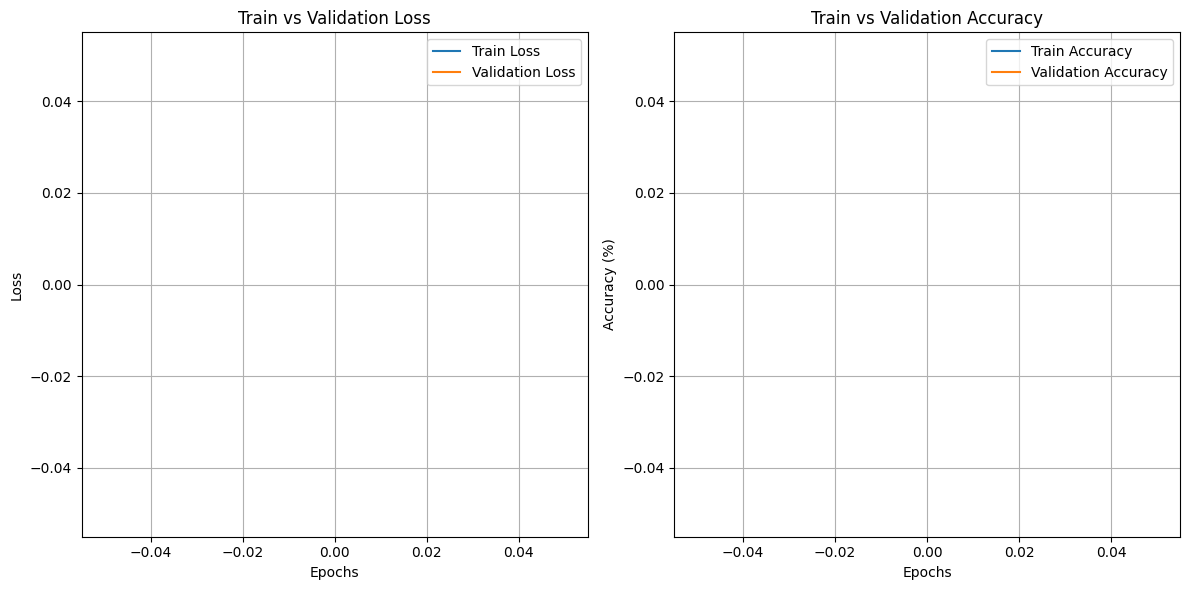

In [41]:
import matplotlib.pyplot as plt

# Vẽ đồ thị loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss')
plt.legend()
plt.grid(True)

# Vẽ đồ thị accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Train Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Train vs Validation Accuracy')
plt.legend()
plt.grid(True)

# Hiển thị đồ thị
plt.tight_layout()
plt.show()


In [ ]:
# Load trạng thái đã lưu
model.load_state_dict(torch.load("/kaggle/input/modelstate/model_2.pth"))

# Đặt mô hình ở chế độ đánh giá
model.eval()

In [42]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Đặt mô hình ở chế độ đánh giá
model.eval()

# Biến để lưu nhãn và dự đoán
all_labels = []
all_preds = []

# Không tính gradient khi đánh giá
with torch.no_grad():
    for inputs, labels in test_loader:
        # Chuyển dữ liệu sang thiết bị phù hợp (CPU/GPU)
        inputs, labels = inputs.to(device), labels.to(device)

        # Dự đoán
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

        # Lưu nhãn thật và dự đoán
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

# Sử dụng sklearn để tính toán các chỉ số
accuracy = accuracy_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds, average=None)  # None để tính cho từng nhãn
precision = precision_score(all_labels, all_preds, average=None)
f1 = f1_score(all_labels, all_preds, average=None)


In [43]:
# Báo cáo chi tiết
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=test_dataset.labels))


Classification Report:
                  precision    recall  f1-score   support

        Banh beo       0.89      0.76      0.82       129
    Banh bot loc       0.67      0.69      0.68       144
        Banh can       0.88      0.70      0.78       149
       Banh canh       0.64      0.42      0.51       193
      Banh chung       0.53      0.74      0.62       102
       Banh cuon       0.83      0.67      0.74       228
        Banh duc       0.52      0.43      0.47       133
        Banh gio       0.84      0.71      0.77       129
       Banh khot       0.89      0.77      0.82       167
         Banh mi       0.65      0.93      0.76       268
        Banh pia       0.79      0.82      0.81        89
        Banh tet       0.78      0.56      0.65       138
Banh trang nuong       0.73      0.75      0.74       159
        Banh xeo       0.75      0.80      0.78       235
      Bun bo Hue       0.73      0.75      0.74       306
 Bun dau mam tom       0.94      0.91      0.93

In [47]:
from PIL import Image
import torch
import torchvision.transforms as transforms

def predict_image(img_path, model, device, class_names):
    image = Image.open(img_path).convert('RGB')
    preprocess = transforms.Compose([
        transforms.Resize((224, 224)),  # Thay đổi kích thước phù hợp với mô hình
        transforms.ToTensor(),         # Chuyển ảnh thành tensor
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    image_tensor = preprocess(image).unsqueeze(0)  # Thêm chiều batch
    image_tensor = image_tensor.to(device)
    model.eval()
    with torch.no_grad():
        outputs = model(image_tensor)
        _, predicted = torch.max(outputs, 1)
    predicted_class = class_names[predicted.item()]
    return predicted_class

# Ví dụ sử dụng
class_names = ['Banh beo',
 'Banh bot loc',
 'Banh can',
 'Banh canh',
 'Banh chung',
 'Banh cuon',
 'Banh duc',
 'Banh gio',
 'Banh khot',
 'Banh mi',
 'Banh pia',
 'Banh tet',
 'Banh trang nuong',
 'Banh xeo',
 'Bun bo Hue',
 'Bun dau mam tom',
 'Bun mam',
 'Bun rieu',
 'Bun thit nuong',
 'Bánh cu đơ',
 'Bánh mì cay',
 'Bánh đa cua',
 'Bánh đậu xanh',
 'Bò bía',
 'Bún cá',
 'Ca kho to',
 'Canh chua',
 'Cao lau',
 'Chao long',
 'Com tam',
 'Cơm cháy',
 'Goi cuon',
 'Hu tieu',
 'Mi quang',
 'Nem chua',
 'Nem nướng',
 'Pho',
 'Xoi xeo']
img_path = "/kaggle/input/ffdfsdffds/r1.jpg"
predicted_label = predict_image(img_path, model, device, class_names)
print(f"Dự đoán: {predicted_label}")

Dự đoán: Canh chua
